In [9]:
import enum
import itertools
import random
import dataclasses
import collections
import numpy as np
from scipy.special import softmax
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
from typing import Tuple, List, Dict
import torch

np.random.seed(42)

class GridWorldCell(enum.Enum):
  DIRT = 0
  GRASS = 1
  LAVA = 2
  GOAL = 3

class GridWorldActionSpace(enum.Enum):
  NORTH = (0, -1)
  SOUTH = (0, 1)
  EAST  = (1, 0)
  WEST  = (-1, 0)

class Reward:
  def __init__(self, weights: list[float], features: list[GridWorldCell]):
    self._features = features
    self._weights = weights

  @property
  def weights(self):
    return self._weights

  @property
  def features(self):
    return self._features

  @property
  def num_features(self):
    if self._features is None:
      raise ValueError('Features not set.')
    return len(self._features)

  # def encode_feature(self, inputs: GridWorldCell) -> int:
  #   cell_index = self._features.index(inputs)
  #   one_hot_enc = np.identity(len(self._features))[cell_index]
  #   return one_hot_enc

  def __call__(self, inputs: GridWorldCell) -> float:
    one_hot_enc = self.encode_feature(inputs)
    return np.dot(self._weights, one_hot_enc)

  def __repr__(self):
    return f"{self._weights}"

  def __str__(self)->str:
    s = []
    for feat, w in zip(self._features, self._weights):
      s.append(f"{feat}*{w}")
    return ",".join(s)

D, GR, L, GO = GridWorldCell.DIRT, GridWorldCell.GRASS, GridWorldCell.LAVA, GridWorldCell.GOAL

@dataclasses.dataclass(frozen=True)
class State:
  x: int
  y: int
  terrain: GridWorldCell

class GridWorldMdp:
  def __init__(self, grid: list[list[GridWorldCell]], reward: Reward, noise: float=0.0, initial_state_xy=(0,0)):
    self._grid = grid
    self._reward = reward
    self._noise = noise
    self._initial_state_xy = initial_state_xy


  def encode_feature(self, inputs: GridWorldCell) -> int:
    return self._reward.encode_feature(inputs.terrain)

  @property
  def grid_dimensions(self):
    height, width = len(self._grid), len(self._grid[0])
    return height, width

  @property
  def get_reward(self) -> Reward:
    return self._reward

  @property
  def get_initial_state(self) -> State:
    x, y = self._initial_state_xy
    return State(x, y, self._grid[y][x])

  @property
  def get_actions(self):
    return [GridWorldActionSpace.NORTH,
            GridWorldActionSpace.EAST,
            GridWorldActionSpace.SOUTH,
            GridWorldActionSpace.WEST]

  def get_state(self, x: int, y: int) -> State:
    return self.get_states[y][x]
    # return self.get_states[y*len(self._grid) + x]

  @property
  def get_states(self) -> list[State]:
    n = len(self._grid)
    m = len(self._grid[0])
    states = []
    for y in range(n):
      row = []
      for x in range(m):
        row.append(State(x, y, self._grid[y][x]))
      states.append(row)
    return states

  def get_transition_probability(self, state: State, action: GridWorldActionSpace):
    next_states = {}
    the_s_prime = self._move(state, action)
    next_states[(action, the_s_prime)] = 1.0 - self._noise
    other_actions = [a for a in self.get_actions if a != action]
    for act in other_actions:
      s_prime = self._move(state, act)
      next_states[(act, s_prime)] = self._noise/len(other_actions)
    return next_states

  def _move(self, state: State, action: GridWorldActionSpace):
    y, x = state.y, state.x
    dx, dy = action.value
    y_next = y + dy
    x_next = x + dx
    # Don't go out of bounds.
    if y_next >= len(self._grid) or y_next < 0:
      y_next = y
    if x_next >= len(self._grid[0]) or x_next < 0:
      x_next = x
    return State(x_next, y_next, self._grid[y_next][x_next])

class GridWorldEnv:
  def __init__(self, mdp):
    self._mdp = mdp
    self._state = mdp.get_initial_state

  @property
  def initial_state(self) -> State:
    return self._mdp.get_initial_state

  @property
  def is_done(self) -> bool:
    return self._state.terrain == GridWorldCell.GOAL

  @property
  def current_state(self) -> State:
    return self._state

  def step(self, action) -> tuple[State, float, bool]:
    T = self._mdp.get_transition_probability(self._state, action)
    rand = random.random()
    cdf = 0.0
    for (act, s_next), p in T.items():
      cdf += p
      if cdf > 1.0:
        raise ValueError('Total transition probability is greater than one.')
      if rand <= cdf:
        r = self._mdp.get_reward(s_next.terrain)
        self._state = s_next
        return s_next, r, self.is_done
    raise ValueError('Total transition probability less than one.')

In [8]:
class BaselineSolver:

  def __init__(self, proxy_reward: Reward, num_value_iteration: int = 100, gamma: float = 0.9):
    self._proxy_reward = proxy_reward
    self._num_value_iteration = num_value_iteration
    self._gamma = gamma

  def solve_policy(self, mdp: GridWorldMdp)->list[list[int]]:
    height, width = mdp.grid_dimensions
    value_func = np.zeros((height, width))
    q_values = np.zeros((height, width, len(mdp.get_actions)))
    policy = np.zeros((height, width))

    for i in range(self._num_value_iteration):
      old_value_func = value_func.copy()
      for h in range(height):
        for w in range(width):
          for i, action in enumerate(mdp.get_actions):
            x_prime = w + action.value[0]
            y_prime = h + action.value[1]
            if 0 <= y_prime < height and 0 <= x_prime < width:
              future_value = old_value_func[y_prime, x_prime]
            else:
              future_value = 0
            q_values[h, w, i] = self._proxy_reward(mdp.get_state(w, h).terrain) + self._gamma*future_value
          value_func[h, w] = np.max(q_values[h, w, :])
      if np.allclose(value_func, old_value_func):
        print("Value Iteration converged after %d steps"%i)
        break
    for h in range(height):
      for w in range(width):
        policy[h, w] = np.argmax(q_values[h, w, :])
    return policy

class IRDSolverQItr:
  """The goal is to compute posterior probability of the optimal reward weights (w*).
  Needs access to MDP to compute feature expectations using Q-iteration.
  """
  def __init__(self, proxy_reward: Reward, beta: float = 1.0, num_value_iteration: int = 100, gamma: float = 0.9):
    self._beta = beta
    self._proxy_reward = proxy_reward
    self._num_value_iteration = num_value_iteration
    self._gamma = gamma

  def sample_from_posterior(self, posterior: list[float], n=1):
    sample = np.random.multinomial(n, posterior)
    return sample

  def solve(self, mdp: GridWorldMdp, true_reward_matrix: list[Reward], true_log_prior: list[float]) -> list[float]:
    expected_features = self._compute_expected_features(mdp)  # ϕ̃
    true_reward_matrix = np.array([r.weights for r in true_reward_matrix])
    log_likelihoods_new = self._beta * (expected_features @ true_reward_matrix.T)
    log_Z_w = logsumexp(log_likelihoods_new, axis=0)  # Denominator for the likelihood
    log_P_z = log_likelihoods_new - log_Z_w  # Numerator of the posterior formula
    log_z = logsumexp(log_P_z + true_log_prior)  # Denominator of the posterior formula
    log_posterior = log_P_z + true_log_prior - log_z
    posterior = np.exp(log_posterior)
    return posterior

  def _compute_expected_features(self, mdp)->list[float]:
    """Computes the expected discounted feature counts.

This corresponds to E[ϕ̃(psi)|psi~pi(psi|proxy reward)]. The policy is max. entropy:
pi(psi|proxy weights) ~ exp(proxy weights * ϕ(psi).
    """
    height, width = mdp.grid_dimensions
    num_features = self._proxy_reward.num_features
    v_features = np.zeros((height, width, num_features))
    for i in range(self._num_value_iteration):
      prev_v_features = v_features.copy()
      for y in range(height):
        for x in range(width):
          q_features_for_state = []
          for action in mdp.get_actions:
            x_prime = x + action.value[0]
            y_prime = y + action.value[1]
            if 0 <= y_prime < height and 0 <= x_prime < width:
              future_features = prev_v_features[y_prime, x_prime, :]
            else:
              future_features = np.zeros(num_features)
            # Q(s,a) = Features(s) + gamma * V(s')
            immediate_features = self._proxy_reward.encode_feature(mdp.get_state(x, y).terrain)
            q_features_for_state.append(immediate_features + self._gamma * future_features)
          # From the paper: pi ~ exp(w.T(features))
          probs = np.array(softmax([np.dot(q_vec, self._proxy_reward._weights) for q_vec in q_features_for_state])) # Not sure if the normalization constant here is correct.
          probs = probs[:, np.newaxis]
          # Expectations over the features
          v_features[y, x, :] = np.sum(probs * q_features_for_state, axis=0)
      if np.allclose(v_features, prev_v_features):
        print("Value iteration converged after %d steps"%i)
        break
    print(v_features)
    return v_features[mdp.get_initial_state.y, mdp.get_initial_state.x, :]

  def solve_policy(self, mdp: GridWorldMdp, sampled_weights: list[list[float]]) -> list[list[int]]:
    """Risk averse trajectory optimization using time-step independent reward."""
    height, width = mdp.grid_dimensions
    worst_case_rewards = np.zeros((height, width))

    for h in range(height):
      for w in range(width):
        state = mdp.get_state(w, h)
        state_features = mdp.encode_feature(state) # Get phi(s)
        # Calculate reward for this state under ALL sampled weights
        all_rewards = sampled_weights @ state_features
        # The reward for this state is the minimum (worst case)
        worst_case_rewards[h, w] = np.min(all_rewards)

    value_func = np.zeros((height, width))
    actions = [a.value for a in mdp.get_actions]

    for _ in range(self._num_value_iteration):
      prev_value_func = value_func.copy()
      for h in range(height):
        for w in range(width):
          q_values = []
          for action in actions:
            h_prime, w_prime = h + action[1], w + action[0]
            if 0 <= h_prime < height and 0 <= w_prime < width:
              future_value = prev_value_func[h_prime, w_prime]
            else:
              future_value = 0
            q_value = worst_case_rewards[h, w] + self._gamma * future_value
            q_values.append(q_value)
          value_func[h, w] = np.max(q_values)

    policy = np.zeros((height, width), dtype=int)
    for h in range(height):
      for w in range(width):
        q_values = []
        for action in actions:
          h_prime, w_prime = h + action[1], w + action[0]
          if 0 <= h_prime < height and 0 <= w_prime < width:
            future_value = value_func[h_prime, w_prime]
          else:
            future_value = 0
          q_values.append(worst_case_rewards[h, w] + self._gamma * future_value)

        policy[h, w] = np.argmax(q_values)
    return policy

In [10]:
def get_true_reward_matrix(features: list[GridWorldCell], value_range: tuple[int, int], num_points:int = 10, proxy_reward: Reward = None):
  """Creates a list of n-dimensional vectors from a discretized range."""
  if proxy_reward is None:
    # Uniform
    num_features = len(features)
    a, b = value_range
    discrete_points = np.linspace(a, b, num_points)
    vector_space = np.array([Reward(features=features, weights=w) for w in itertools.product(discrete_points, repeat=num_features)])
    num_rewards = len(vector_space)
    log_prior = np.array([1/num_rewards]*num_rewards)  # Uniform prior
    return vector_space, log_prior
  else:
    mvn = torch.distributions.MultivariateNormal(loc=proxy_reward._weights, scale_tril=torch.eye(n=len(proxy_reward._weights)))
    return mvn.sample(num_points), mvn.log_prob(proxy_reward._weights)

In [292]:
def debug_example():
  features = [
    GridWorldCell.DIRT,
    GridWorldCell.GRASS,
    GridWorldCell.LAVA,
    GridWorldCell.GOAL,
  ]
  true_log_prior = np.log(np.array([0.2, 0.2, 0.2, 0.2, 0.2]))
  true_reward_matrix = np.array([
    [-0.1, -20.0, 0, 5],
    [-1.0, -0.5, 0, -10],
    [-1.0, -2.0, 0, 50],
    [-10.0, -20.0, 0, 50],
    [-1.0, -2.0, 100, 50]
  ])
  true_reward_matrix = np.array([Reward(features=features, weights=w) for w in true_reward_matrix])
  return true_reward_matrix, true_log_prior

In [33]:
def sample_reward_from_posterior(ird, posterior, true_reward_matrix, n = 1):
  ids = ird.sample_from_posterior(posterior, n)
  reward = true_reward_matrix[ids != 0]
  reward = [x._weights for x in reward]
  return reward

In [294]:
true_reward_matrix, true_log_prior = get_true_reward_matrix([
        GridWorldCell.DIRT,
        GridWorldCell.GRASS,
        GridWorldCell.LAVA,
        GridWorldCell.GOAL,
    ], [0, 10], num_points=10)
true_reward = Reward(
    weights=[-2.0, -1.0, -100, 50],
    features=[
        GridWorldCell.DIRT,
        GridWorldCell.GRASS,
        GridWorldCell.LAVA,
        GridWorldCell.GOAL,
    ]
)
proxy_reward = Reward(
    weights=[-2.0, -1.0, 0.23, 50], # Should set to rand().
    features=[
        GridWorldCell.DIRT,
        GridWorldCell.GRASS,
        GridWorldCell.LAVA,
        GridWorldCell.GOAL,
    ]
)
train_grid = [
    [D, GR, GR, D],
    [D, GR, GR, GO],
    [D, GR, GR, D],
    [D, GR, D, D]
]
test_grid = [
    [D, L, L, D],
    [D, L, L, GO],
    [D, L, L, D],
    [D, GR, D, D]
]
train_mdp = GridWorldMdp(train_grid, true_reward, noise=0.0)
train_env = GridWorldEnv(train_mdp)

test_mdp = GridWorldMdp(test_grid, true_reward, noise=0.0)
test_env = GridWorldEnv(test_mdp)

ird = IRDSolverQItr(proxy_reward, beta=0.9, gamma=0.9, num_value_iteration=100)
posterior = ird.solve(train_mdp, true_reward_matrix, true_log_prior)

sampled_weights = sample_reward_from_posterior(ird, posterior, true_reward_matrix, n=50)
print(sampled_weights)
print(test_mdp._grid)
ird_policy = ird.solve_policy(test_mdp, sampled_weights)
print(ird_policy)

baseline = BaselineSolver(proxy_reward)
baseline_policy = baseline.solve_policy(test_mdp)
print(baseline_policy)

Value iteration converged after 98 steps
[[[2.73575936 3.81092741 0.         3.4530181 ]
  [1.65199134 4.51100788 0.         3.83668678]
  [1.98078591 3.75590087 0.         4.2630181 ]
  [2.91182897 2.35117025 0.         4.73668678]]

 [[2.54856795 3.61443127 0.         3.83668678]
  [1.72064046 4.01604631 0.         4.2630181 ]
  [1.91182897 3.35117025 0.         4.73668678]
  [2.12426382 2.61242295 0.         5.2630181 ]]

 [[2.73575936 3.81092741 0.         3.4530181 ]
  [1.65199134 4.51100788 0.         3.83668678]
  [1.98078591 3.75590087 0.         4.2630181 ]
  [2.91182897 2.35117025 0.         4.73668678]]

 [[2.84596527 4.04603395 0.         3.10768678]
  [1.76523057 4.7814562  0.         3.4530181 ]
  [3.05728751 3.10571171 0.         3.83668678]
  [3.62064046 2.11604631 0.         4.2630181 ]]]
[(np.float64(8.88888888888889), np.float64(10.0), np.float64(0.0), np.float64(10.0)), (np.float64(8.88888888888889), np.float64(10.0), np.float64(2.2222222222222223), np.float64(10.0)

[[2 3 1 2]
 [2 3 1 2]
 [2 2 2 2]
 [1 1 3 3]]


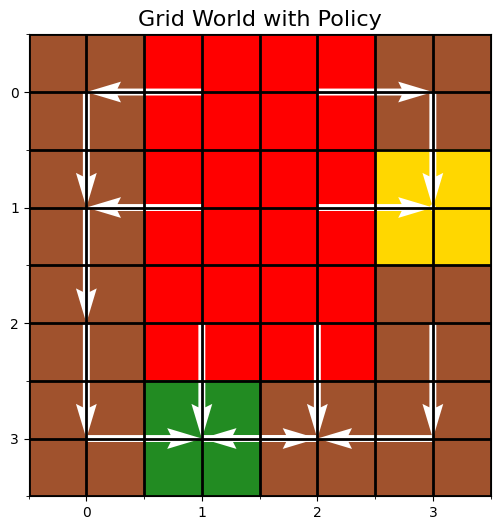

In [ ]:
import matplotlib.colors as mcolors

def visualize_grid_policy(grid_spec, policy):
    """
    Visualizes a grid world and a policy.

    Args:
        grid_spec (list of lists): A 2D list defining the terrain of the grid.
        policy (np.ndarray): A 2D numpy array with the same dimensions as the grid,
                             containing integer actions.
    """
    print(policy)
    # 1. Convert the descriptive grid into a numerical grid
    # terrain_map = {'D': GridWorldCell.DIRT.value, 'GR': GridWorldCell.GRASS.value, 'GO': GridWorldCell.GOAL.value}
    grid_numeric = np.array([[cell.value for cell in row] for row in grid_spec])
    rows, cols = grid_numeric.shape

    # 2. Define colors for each terrain type
    colors = {
        GridWorldCell.DIRT.value: '#A0522D',  # Brown
        GridWorldCell.GRASS.value: '#228B22', # Green
        GridWorldCell.LAVA.value: '#FF0000',  # Red
        GridWorldCell.GOAL.value: '#FFD700'   # Gold
    }
    cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
    bounds = list(sorted(colors.keys())) + [max(colors.keys()) + 1]
    norm = mcolors.BoundaryNorm(np.array(bounds)-0.5, cmap.N)

    # 3. Plot the grid and, if provided, the policy arrows
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw the colored grid cells
    ax.imshow(grid_numeric, cmap=cmap, norm=norm)

    # If a policy is provided, overlay the arrows
    if policy is not None:
        # Action mapping: 0:N, 1:E, 2:S, 3:W
        action_vectors = {
            0: (0, -1), 1: (1, 0),
            2: (0, 1), 3: (-1, 0)
        }

        U = np.zeros_like(policy, dtype=float)
        V = np.zeros_like(policy, dtype=float)

        for r in range(rows):
            for c in range(cols):
                if grid_numeric[r, c] != GridWorldCell.GOAL.value:
                    action = policy[r, c]
                    dx, dy = action_vectors[action]
                    U[r, c], V[r, c] = dx, dy

        x_coords, y_coords = np.meshgrid(np.arange(cols), np.arange(rows))
        ax.quiver(x_coords, y_coords, U, V, scale=1, scale_units='xy', angles='xy', color='white', width=0.015)
        ax.set_title('Grid World with Policy', fontsize=16)
    else:
        ax.set_title('Grid World Terrain', fontsize=16)

    # 4. Beautify the plot
    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(rows))
    ax.set_xticklabels(np.arange(cols))
    ax.set_yticklabels(np.arange(rows))

    ax.grid(which='major', color='black', linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    plt.show()

visualize_grid_policy(test_grid, ird_policy)

[[1. 1. 2. 2.]
 [1. 1. 1. 3.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


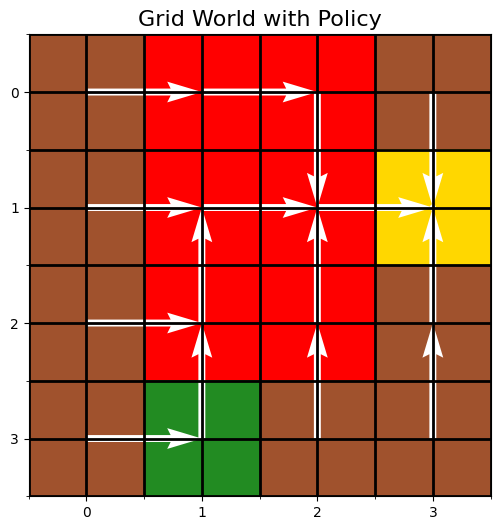

In [ ]:
visualize_grid_policy(test_grid, baseline_policy)

None


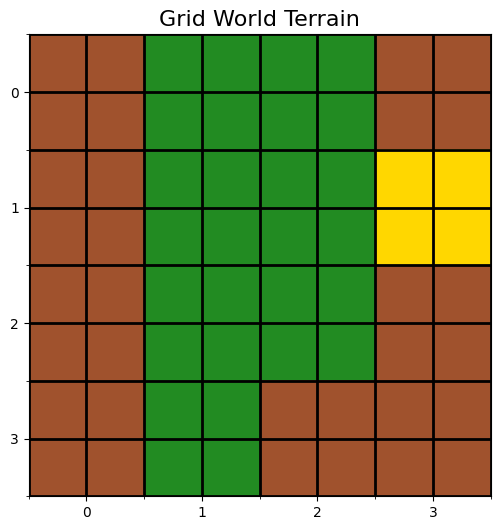

In [ ]:
visualize_grid_policy(train_grid, None)

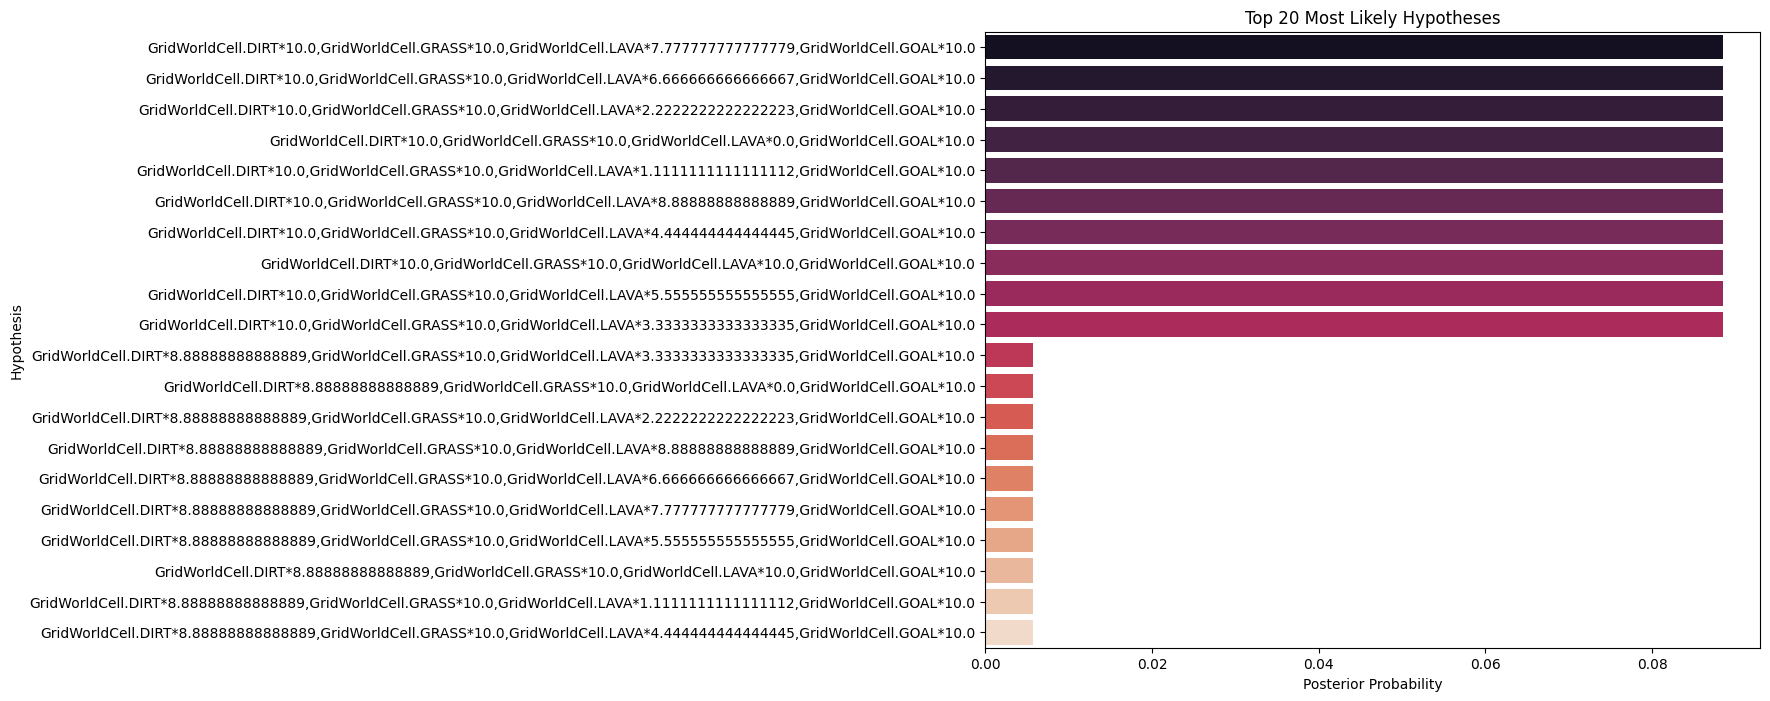

In [295]:
df = pd.DataFrame({'Hypothesis': [str(true_reward_matrix[i]) for i in list(range(len(true_reward_matrix)))], 'Probability': posterior})
df_sorted = df.sort_values(by='Probability', ascending=False)

top_n = 20
df_top = df_sorted.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x='Probability', y='Hypothesis', data=df_top, palette='rocket', hue='Hypothesis', legend=False)
plt.xlabel('Posterior Probability')
plt.ylabel('Hypothesis')
plt.title(f'Top {top_n} Most Likely Hypotheses')
plt.show()

# Plot entropy vs. beta

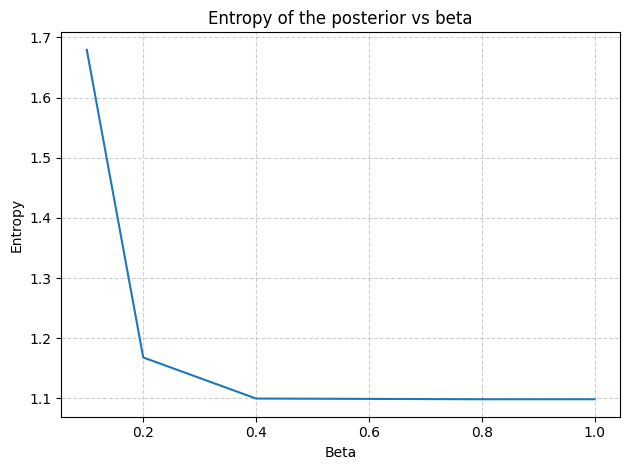

In [ ]:
betas = [0.1, 0.2, 0.4, 0.8, 1.0]
solvers = [IRDSolverQItr(reward, beta=b) for b in betas]
posteriors = [ird.solve(mdp, true_reward_matrix, true_log_prior) for ird in solvers]

entropies = [entropy(p) for p in posteriors]
sns.lineplot(x=betas, y=entropies)
plt.title('Entropy of the posterior vs beta')
plt.xlabel('Beta')
plt.ylabel('Entropy')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Hungry-Thirsty

In [1]:
import enum
import itertools
import random
import dataclasses
import collections
import numpy as np
from scipy.special import softmax
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
from typing import Tuple, List, Dict
from typing import Any
from sklearn.preprocessing import normalize
import torch

np.random.seed(42)


class Reward:
  def __init__(self, weights: list[float], features: list[Any]):
    self._features = features
    self._weights = weights

  @property
  def weights(self):
    return self._weights

  @property
  def features(self):
    return self._features

  @property
  def num_features(self):
    if self._features is None:
      raise ValueError('Features not set.')
    return len(self._features)

  def encode_feature(self, inputs) -> int:
    # breakpoint()
    cell_index = self._features.index(inputs)
    one_hot_enc = np.identity(len(self._features))[cell_index]
    return one_hot_enc

  def __call__(self, inputs) -> float:
    one_hot_enc = self.encode_feature(inputs)
    return np.dot(self._weights, one_hot_enc)

  def __repr__(self):
    return f"{self._weights}"

  def __str__(self)->str:
    s = []
    for feat, w in zip(self._features, self._weights):
      s.append(f"{feat}*{w}")
    return ",".join(s)

class AgentState(enum.Enum):
  HUNGRY_THIRSTY = 0
  HUNGRY_NOT_THIRSTY = 1
  NOT_HUNGRY_THIRSTY = 2
  NOT_HUNGRY_NOT_THIRSTY = 3

class HungryThirstyAction(enum.Enum):
  NORTH = (0, -1)
  SOUTH = (0, 1)
  EAST  = (1, 0)
  WEST  = (-1, 0)
  EAT = 1
  DRINK = 2


def get_true_reward_matrix(features, value_range: tuple[int, int], num_points:int = 10, proxy_reward: Reward = None, beta: float=1.0):
  """Creates a list of n-dimensional vectors from a discretized range."""
  if proxy_reward is None:
    # Uniform
    num_features = len(features)
    a, b = value_range
    discrete_points = np.linspace(a, b, num_points)
    vector_space = np.array([Reward(features=features, weights=w) for w in itertools.product(discrete_points, repeat=num_features)])
    num_rewards = len(vector_space)
    log_prior = np.array([1/num_rewards]*num_rewards)  # Uniform prior
    return vector_space, log_prior
  else:
    mvn = torch.distributions.MultivariateNormal(torch.tensor(proxy_reward._weights, dtype=torch.float32), beta*torch.eye(n=len(proxy_reward._weights), dtype=torch.float32))
    samples = mvn.sample(sample_shape=(num_points,))
    log_probs = mvn.log_prob(samples)
    log_probs = torch.nn.functional.log_softmax(torch.exp(log_probs), dim=0)
    return np.array([Reward(features=features, weights=w) for w in samples]), log_probs


In [2]:
class HungryThirstyMdp:
  def __init__(self, reward: Reward, width: int = 6, height: int = 6, food_loc: Tuple[int, int]=None, water_loc: Tuple[int, int]=None):
    self._width = width
    self._height = height
    self._food_loc = food_loc
    self._water_loc = water_loc
    self._barriers = self._create_barriers()
    self._reward = reward
    self._movement_actions = [HungryThirstyAction.WEST, HungryThirstyAction.EAST, HungryThirstyAction.SOUTH, HungryThirstyAction.NORTH]
    self._states = self._generate_all_states()

  def _create_barriers(self):
    barriers = set()
    # x, y
    barriers.add((2,0))
    barriers.add((2,1))
    barriers.add((2,2))

    barriers.add((3,2))
    barriers.add((4,2))
    # for y in range(0, 4):
    #   barriers.add((4, y))
    # for x in range(3, 6):
    #   barriers.add((x, 4))
    # for y in range(self._height):
    #   if y != 2:
    #     barriers.add(((2, y), (3, y)))
    #     barriers.add(((3, y), (2, y)))
    # barriers.add(((2,2), (2,3)))
    # barriers.add(((2,3), (2,2)))
    # barriers.add(((4,4), (4,5)))
    # barriers.add(((4,5), (4,4)))
    return barriers

  def _generate_all_states(self) -> List[Tuple[int, int, AgentState]]:
    """Generates the list of all (x, y, AgentState) states."""
    states = []
    for x in range(self._width):
      for y in range(self._height):
        for agent_state in AgentState:
          states.append((x, y, agent_state))
    return states

  @property
  def grid_dimensions(self) -> Tuple[int, int]:
      return (self._width, self._height)

  @property
  def get_reward(self) -> Reward:
      return self._reward

  @property
  def get_initial_state(self) -> Tuple[int, int, AgentState]:
      """Initial state is (0,0, HUNGRY_THIRSTY)"""
      return (0, 0, AgentState.HUNGRY_THIRSTY)

  @property
  def get_agent_states(self):
    return [
        AgentState.NOT_HUNGRY_NOT_THIRSTY,
        AgentState.HUNGRY_NOT_THIRSTY,
        AgentState.NOT_HUNGRY_THIRSTY,
        AgentState.HUNGRY_THIRSTY,
    ]

  @property
  def get_actions(self) -> List[HungryThirstyAction]:
      return [
          HungryThirstyAction.NORTH,
          HungryThirstyAction.SOUTH,
          HungryThirstyAction.WEST,
          HungryThirstyAction.EAST,
          HungryThirstyAction.EAT,
          HungryThirstyAction.DRINK
      ]

  def get_state(self, x: int, y: int, agent_state: AgentState) -> Tuple[int, int, AgentState]:
      """Returns a state tuple given its components."""
      return (x, y, agent_state)

  @property
  def get_states(self) -> List[Tuple[int, int, AgentState]]:
      return self._states

  # def encode_feature(self, state: tuple) -> np.ndarray:
  #   x, y, agent_state = state
  #   height, width = self.grid_dimensions

  #   # One-hot encode the (x, y) position
  #   # Creates a flat array of size height * width
  #   pos_features = np.zeros(height * width)
  #   pos_index = y * width + x
  #   pos_features[pos_index] = 1.0

  #   # One-hot encode the agent's internal state
  #   agent_state_features = np.zeros(len(self.get_agent_states))
  #   state_index = self.get_agent_states.index(agent_state)
  #   agent_state_features[state_index] = 1.0
  #   # Combine them into a single feature vector
  #   return np.concatenate((pos_features, agent_state_features))

  def encode_feature(self, state: Tuple[int, int, AgentState]) -> int:
    x, y, agent_state = state
    return self._reward.encode_feature(agent_state)

  def get_transition_probability(self, state: Tuple[int, int, AgentState], action: HungryThirstyAction):
      """
      Calculates the next state(s) and their transition probabilities and rewards
      for a given state-action pair.
      """
      x, y, current_agent_state = state
      transitions = {}

      # Deconstruct AgentState into bools for logic
      is_hungry = current_agent_state in (AgentState.HUNGRY_THIRSTY, AgentState.HUNGRY_NOT_THIRSTY)
      is_thirsty = current_agent_state in (AgentState.HUNGRY_THIRSTY, AgentState.NOT_HUNGRY_THIRSTY)

      # 1. Determine potential *next location and internal state* from action
      new_x, new_y = x, y
      next_is_hungry, next_is_thirsty = is_hungry, is_thirsty # State after action, before dynamics

      if action in self._movement_actions:
          # Movement logic (unchanged)
          dx, dy = action.value[0], action.value[1]

          new_pos = (x + dx, y + dy)
          if (0 <= new_pos[0] < self._width and
              0 <= new_pos[1] < self._height and
              new_pos not in self._barriers):
              new_x, new_y = new_pos
      elif action == HungryThirstyAction.EAT:
          if (x, y) == self._food_loc and not is_thirsty:
              next_is_hungry = False # Successfully ate
      elif action == HungryThirstyAction.DRINK:
          if (x, y) == self._water_loc:
              next_is_thirsty = False # Successfully drank

      # 2. Apply Time-Step Dynamics and Calculate Rewards

      final_is_hungry = next_is_hungry
      fitness_delta = 1 if not final_is_hungry else 0 # Fitness is gained in a Not-Hungry state

      # Thirst Dynamics: If NOT thirsty (next_is_thirsty=False), it becomes thirsty with P=0.1
      if not next_is_thirsty:
          # Case A: Agent becomes thirsty (P=0.1)
          final_agent_state_A = self._bools_to_agentstate(final_is_hungry, True)
          final_state_A = self.get_state(new_x, new_y, final_agent_state_A)
          transitions[final_state_A] = (0.1, fitness_delta)

          # Case B: Agent remains not-thirsty (P=0.9)
          final_agent_state_B = self._bools_to_agentstate(final_is_hungry, False)
          final_state_B = self.get_state(new_x, new_y, final_agent_state_B)
          transitions[final_state_B] = (0.9, fitness_delta)
      else:
          # Agent remains thirsty (P=1.0)
          final_agent_state = self._bools_to_agentstate(final_is_hungry, True)
          final_state = self.get_state(new_x, new_y, final_agent_state)
          transitions[final_state] = (1.0, fitness_delta)

      return transitions

  def _bools_to_agentstate(self, h: bool, t: bool) -> AgentState:
      """Helper to convert bools back to the enum."""
      if h and t: return AgentState.HUNGRY_THIRSTY
      if h and not t: return AgentState.HUNGRY_NOT_THIRSTY
      if not h and t: return AgentState.NOT_HUNGRY_THIRSTY
      if not h and not t: return AgentState.NOT_HUNGRY_NOT_THIRSTY
      raise ValueError("Invalid bool combination")

In [24]:
class HungryThirstyEnv:
    """
    Manages the current state and execution of the Hungry-Thirsty domain,
    using the AgentState enum.
    """
    def __init__(self, reward: Reward, grid_dim: Tuple[int, int] = (6, 6), food_loc: Tuple[int, int] = (0, 0), water_loc: Tuple[int, int] = (2, 4)):
      # Initialize MDP with defaults or provided locs
      self.mdp = HungryThirstyMdp(reward, width=grid_dim[0], height=grid_dim[1], food_loc=food_loc, water_loc=water_loc)

      self.width, self.height = self.mdp.grid_dimensions
      self.actions = self.mdp.get_actions
      self.movement_actions = self.mdp._movement_actions
      self.barriers = self.mdp._barriers

      # Agent's current state variables
      self.agent_pos: Tuple[int, int] = (0, 0)
      self.agent_state: AgentState = AgentState.HUNGRY_THIRSTY # New state variable

      self.food_loc: Tuple[int, int] = self.mdp._food_loc
      self.water_loc: Tuple[int, int] = self.mdp._water_loc

      # Flag for the previous state's hunger dynamics
      self._was_not_hungry_last_step: bool = False

    def reset(self) -> Tuple[int, int, AgentState]:
        # (omitting the reset of food/water locs which is unchanged)
        h, w = self.mdp.grid_dimensions
        corners = [(0, 0), (0, h), (w, 0), (w, h)]
        # self.food_loc, self.water_loc = random.sample(corners, 2)
        # self.mdp._food_loc = self.food_loc
        # self.mdp._water_loc = self.water_loc

        self.agent_pos = (0,0)

        # Reset internal state to default
        self.agent_state = AgentState.HUNGRY_THIRSTY
        self._was_not_hungry_last_step = False

        return self.get_state()

    def get_state(self) -> Tuple[int, int, AgentState]:
        """Returns the current observable state of the agent."""
        return (self.agent_pos[0], self.agent_pos[1], self.agent_state)

    def step(self, action: int) -> Tuple[Tuple[int, int, AgentState], int, bool, Dict]:
        """
        Executes one time step in the environment.
        - Deconstructs AgentState into bools for logic.
        - Updates AgentState based on actions and dynamics.
        """
        # Deconstruct current state for logic
        is_hungry = self.agent_state in (AgentState.HUNGRY_THIRSTY, AgentState.HUNGRY_NOT_THIRSTY)
        is_thirsty = self.agent_state in (AgentState.HUNGRY_THIRSTY, AgentState.NOT_HUNGRY_THIRSTY)
        action = self.mdp.get_actions[action]
        # 1. State Dynamics Pre-Action

        # Hunger Dynamics: Set is_hungry back to True if it was False last step
        if self._was_not_hungry_last_step:
          is_hungry = True
          self._was_not_hungry_last_step = False

        # Thirst Dynamics: If NOT thirsty, it becomes thirsty with p=0.1
        if not is_thirsty:
          if random.random() < 0.1:
            is_thirsty = True

        # 2. Execute Agent Action (Update is_hungry/is_thirsty)

        if action in self.movement_actions:
          self._move_agent(action)
        elif action == HungryThirstyAction.EAT:
          if self.agent_pos == self.food_loc and not is_thirsty:
            is_hungry = False # Successfully ate
        elif action == HungryThirstyAction.DRINK:
          if self.agent_pos == self.water_loc:
            is_thirsty = False # Successfully drank

        # 3. Calculate Fitness and Prepare Return Values

        # Fitness increments by 1 if agent is NOT hungry after action
        fitness_delta = 1 if not is_hungry else 0

        # Set flag for the next step's hunger dynamics
        if not is_hungry:
          self._was_not_hungry_last_step = True

        # 4. Reconstruct AgentState
        self.agent_state = self.mdp._bools_to_agentstate(is_hungry, is_thirsty)

        done = False
        reward = fitness_delta
        info = {'fitness': fitness_delta}

        return self.get_state(), reward, done, info

    def _move_agent(self, action: HungryThirstyAction):
        # (omitting _move_agent as it is unchanged)
        x, y = self.agent_pos
        dx, dy = action.value[0], action.value[1]

        new_pos = (x + dx, y + dy)

        if (0 <= new_pos[0] < self.width and
            0 <= new_pos[1] < self.height and
            (self.agent_pos, new_pos) not in self.barriers):
            self.agent_pos = new_pos

    def render(self):
      """Prints a simple text-based representation of the grid."""
      grid = [['.' for _ in range(self.width)] for _ in range(self.height)]
      fx, fy = self.food_loc
      wx, wy = self.water_loc
      ax, ay = self.agent_pos

      grid[fy][fx] = 'F'
      grid[wy][wx] = 'W'
      grid[ay][ax] = 'A'

      for y in range(self.height):
          # Print the current content row (y)
          row_str = ""
          for x in range(self.width):
              row_str += (grid[y][x] if (x,y) not in self.mdp._barriers else "X")
              # # Draw vertical barrier (or space) *after* the cell content
              # if x == 2:
              #     if y != 2:
              #         row_str += "|"
              #     else:
              #         row_str += " "
              # else:
              row_str += " "
          print(row_str)
      is_hungry = self.agent_state in (AgentState.HUNGRY_THIRSTY, AgentState.HUNGRY_NOT_THIRSTY)
      is_thirsty = self.agent_state in (AgentState.HUNGRY_THIRSTY, AgentState.NOT_HUNGRY_THIRSTY)
      print(f"State: Hungry={is_hungry}, Thirsty={is_thirsty}\n")

In [4]:
def sample_reward_from_posterior(ird, posterior, true_reward_matrix, n = 1):
  ids = ird.sample_from_posterior(posterior, n)
  reward = true_reward_matrix[ids != 0]
  reward = [x._weights for x in reward]
  return reward

In [85]:
env = HungryThirstyEnv(proxy_reward, food_loc=(5,0), water_loc=(5,5))
env.render()

env.mdp.get_transition_probability((1, 3, AgentState.NOT_HUNGRY_NOT_THIRSTY), HungryThirstyAction.EAST)

A . X . . F 
. . X . . . 
. . X X X . 
. . . . . . 
. . . . . . 
. . . . . W 
State: Hungry=True, Thirsty=True



{(2, 3, <AgentState.NOT_HUNGRY_THIRSTY: 2>): (0.1, 1),
 (2, 3, <AgentState.NOT_HUNGRY_NOT_THIRSTY: 3>): (0.9, 1)}

In [25]:
proxy_reward = Reward(
    weights=[10, 5, 0, -10],
    # weights=[-10, -10, -10, 10],
    features=[
        AgentState.NOT_HUNGRY_NOT_THIRSTY,
        AgentState.HUNGRY_NOT_THIRSTY,
        AgentState.NOT_HUNGRY_THIRSTY,
        AgentState.HUNGRY_THIRSTY,
    ]
)

true_reward = Reward(
  weights=[-0.05, -0.01, 1.0, 0.5],
  features=[
    AgentState.NOT_HUNGRY_NOT_THIRSTY,
    AgentState.HUNGRY_NOT_THIRSTY,
    AgentState.NOT_HUNGRY_THIRSTY,
    AgentState.HUNGRY_THIRSTY,
])

true_reward_matrix, true_log_prior = get_true_reward_matrix([
  AgentState.NOT_HUNGRY_NOT_THIRSTY,
  AgentState.HUNGRY_NOT_THIRSTY,
  AgentState.NOT_HUNGRY_THIRSTY,
  AgentState.HUNGRY_THIRSTY],
   [-10, 10], num_points=25)

train_env = HungryThirstyEnv(proxy_reward, grid_dim=(6,6), food_loc=(5,0), water_loc=(5,5))
test_env = HungryThirstyEnv(proxy_reward, grid_dim=(6,6), food_loc=(0,5), water_loc=(5,0))

solver = IRDSolverQItr(proxy_reward, beta=0.8, gamma=0.99, num_value_iteration=1000)
posterior=solver.solve(train_env.mdp, true_reward_matrix, true_log_prior)

sampled_weights = sample_reward_from_posterior(solver, posterior, true_reward_matrix, n=50)
print(sampled_weights)
# print(test_mdp._grid)
ird_policy = solver.solve_policy(test_env.mdp, sampled_weights)
print(ird_policy)

baseline = BaselineSolver(proxy_reward)
baseline_policy = baseline.solve_policy(test_env.mdp)
print(baseline_policy)

Softmax Policy Evaluation converged after 711 steps.
[(np.float64(-10.0), np.float64(-10.0), np.float64(4.166666666666668), np.float64(0.8333333333333339)), (np.float64(-10.0), np.float64(2.5), np.float64(6.666666666666668), np.float64(4.166666666666668)), (np.float64(-7.5), np.float64(0.0), np.float64(-0.8333333333333321), np.float64(-4.166666666666666)), (np.float64(-6.666666666666666), np.float64(8.333333333333336), np.float64(-1.666666666666666), np.float64(0.8333333333333339)), (np.float64(-6.666666666666666), np.float64(10.0), np.float64(-3.333333333333333), np.float64(10.0)), (np.float64(-5.833333333333333), np.float64(-4.166666666666666), np.float64(-10.0), np.float64(-0.8333333333333321)), (np.float64(-5.833333333333333), np.float64(6.666666666666668), np.float64(7.5), np.float64(0.0)), (np.float64(-5.0), np.float64(6.666666666666668), np.float64(5.833333333333334), np.float64(3.333333333333334)), (np.float64(-3.333333333333333), np.float64(-0.8333333333333321), np.float64(4.1

In [27]:
def evaluate_policy(policy, env, num_steps):
  total_reward = 0
  state = env.reset()
  print(state)
  for _ in range(num_steps):
    x, y, agent_state = state
    agent_state_i = env.mdp.get_agent_states.index(agent_state)
    action = policy[(y,x,agent_state_i)]
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
      print("done")
      state = env.reset()
    print(state)
    total_reward += reward
  return total_reward

print(evaluate_policy(baseline_policy, test_env, 40))

(0, 0, <AgentState.HUNGRY_THIRSTY: 0>)
(0, 1, <AgentState.HUNGRY_THIRSTY: 0>)
(0, 2, <AgentState.HUNGRY_THIRSTY: 0>)
(0, 3, <AgentState.HUNGRY_THIRSTY: 0>)
(1, 3, <AgentState.HUNGRY_THIRSTY: 0>)
(2, 3, <AgentState.HUNGRY_THIRSTY: 0>)
(3, 3, <AgentState.HUNGRY_THIRSTY: 0>)
(4, 3, <AgentState.HUNGRY_THIRSTY: 0>)
(5, 3, <AgentState.HUNGRY_THIRSTY: 0>)
(5, 2, <AgentState.HUNGRY_THIRSTY: 0>)
(5, 1, <AgentState.HUNGRY_THIRSTY: 0>)
(5, 0, <AgentState.HUNGRY_THIRSTY: 0>)
(5, 0, <AgentState.HUNGRY_NOT_THIRSTY: 1>)
(5, 1, <AgentState.HUNGRY_NOT_THIRSTY: 1>)
(5, 2, <AgentState.HUNGRY_NOT_THIRSTY: 1>)
(5, 3, <AgentState.HUNGRY_THIRSTY: 0>)
(5, 2, <AgentState.HUNGRY_THIRSTY: 0>)
(5, 1, <AgentState.HUNGRY_THIRSTY: 0>)
(5, 0, <AgentState.HUNGRY_THIRSTY: 0>)
(5, 0, <AgentState.HUNGRY_NOT_THIRSTY: 1>)
(5, 1, <AgentState.HUNGRY_NOT_THIRSTY: 1>)
(5, 2, <AgentState.HUNGRY_NOT_THIRSTY: 1>)
(5, 3, <AgentState.HUNGRY_NOT_THIRSTY: 1>)
(5, 4, <AgentState.HUNGRY_NOT_THIRSTY: 1>)
(5, 5, <AgentState.HUNGRY_THIRST

In [7]:
class BaselineSolver:
  def __init__(self, proxy_reward: Reward, num_value_iteration: int = 1000, gamma: float = 0.99):
    self._proxy_reward = proxy_reward
    self._num_value_iteration = num_value_iteration
    self._gamma = gamma

  def solve_policy(self, mdp)->list[list[int]]:
    height, width = mdp.grid_dimensions
    value_func = np.zeros((height, width, len(mdp.get_agent_states))) # Number of agent states
    # actions = [a.value for a in mdp.get_actions]
    num_features = self._proxy_reward.num_features

    for _ in range(self._num_value_iteration):
      prev_value_func = value_func.copy()
      for h in range(height):
        for w in range(width):
          for j, agent_state in enumerate(mdp.get_agent_states):
            current_state = mdp.get_state(w, h, agent_state)
            q_values_for_state = []
            for k, action in enumerate(mdp.get_actions):
              expected_future_value = 0.0
              transitions = mdp.get_transition_probability(current_state, action)
              expected_r = 0.0
              # Calculate reward based on the next state or the current state?
              for next_cell, (prob, _) in transitions.items():
                next_x, next_y, next_agent_state = next_cell
                next_j = mdp.get_agent_states.index(next_agent_state)
                expected_future_value += prob * prev_value_func[next_y, next_x, next_j]
                expected_r += prob * np.dot(self._proxy_reward._weights, mdp.encode_feature(next_cell))
              Q_a = expected_r + self._gamma * expected_future_value
              q_values_for_state.append(Q_a)
            value_func[h, w, j] = np.max(q_values_for_state)
      if np.allclose(prev_value_func, value_func, 1e-6):
        print("Converged after %d steps"%_)
        break
    print(value_func)
    policy = np.zeros((height, width,len(mdp.get_agent_states)), dtype=int)
    for h in range(height):
      for w in range(width):
        for j, agent_state in enumerate(mdp.get_agent_states):
          q_values = []
          current_state = mdp.get_state(w,h,agent_state)
          for k, action in enumerate(mdp.get_actions):
            expected_future_value = 0.0
            transitions = mdp.get_transition_probability(current_state, action)
            expected_r = 0.0
            for next_cell, (prob, _) in transitions.items():
              next_x, next_y, next_agent_state = next_cell
              next_j = mdp.get_agent_states.index(next_agent_state)
              expected_future_value += prob * value_func[next_y, next_x, next_j]
              expected_r += prob * np.dot(self._proxy_reward._weights, mdp.encode_feature(next_cell))
            Q_a = expected_r + self._gamma * expected_future_value
            q_values.append(Q_a)
          policy[h, w, j] = np.argmax(q_values)
    return policy

class IRDSolverQItr:
  def __init__(self, proxy_reward: Reward, beta: float = 0.8, num_value_iteration: int = 1000, gamma: float = 0.99):
    self._beta = beta
    self._proxy_reward = proxy_reward
    self._num_value_iteration = num_value_iteration
    self._gamma = gamma

  def sample_from_posterior(self, posterior: list[float], n=1):
    sample = np.random.multinomial(n, posterior)
    return sample

  def solve_policy(self, mdp: HungryThirstyMdp, sampled_weights: list[list[float]]) -> list[list[int]]:
    """Risk averse trajectory optimization using time-step independent reward."""
    height, width = mdp.grid_dimensions
    worst_case_rewards = np.zeros((height, width, len(mdp.get_agent_states), len(mdp.get_actions)))
    sampled_weights = np.array([x for x in sampled_weights])

    # sampled_weights = np.array([x.numpy() else x for x in sampled_weights])
    for h in range(height):
      for w in range(width):
        for j, agent_state in enumerate(mdp.get_agent_states):
          for k, a in enumerate(mdp.get_actions):
            current_state = mdp.get_state(w, h, agent_state)
            transitions = mdp.get_transition_probability(current_state, a)
            rew = np.zeros((np.shape(sampled_weights)[0]))
            for next_cell, (prob, _) in transitions.items():
              _, _, next_agent_state = next_cell
              state_features = mdp.encode_feature(next_cell) # Get phi(s)
              # Calculate reward for this state under ALL sampled weights
              all_rewards = sampled_weights @ state_features
              # breakpoint()
              # assert np.shape(rew) == np.shape(all_rewards)
              rew += prob * all_rewards
            # breakpoint()
            # The reward for this state is the minimum (worst case)
            worst_case_rewards[h, w, j, k] = np.min(rew) # Reward also depends on the action taken?
    print("Worst_case:")
    print(worst_case_rewards)
    value_func = np.zeros((height, width, len(mdp.get_agent_states))) # Number of agent states
    num_features = self._proxy_reward.num_features

    for _ in range(self._num_value_iteration):
      prev_value_func = value_func.copy()
      for h in range(height):
        for w in range(width):
          for j, agent_state in enumerate(mdp.get_agent_states):
            current_state = mdp.get_state(w, h, agent_state)
            q_values_for_state = []
            for k, action in enumerate(mdp.get_actions):
              # 1. Calculate the expected future value from all possible next states
              expected_future_value = 0.0
              transitions = mdp.get_transition_probability(current_state, action)
              for next_cell, (prob, _) in transitions.items():
                next_x, next_y, next_agent_state = next_cell
                next_j = mdp.get_agent_states.index(next_agent_state)
                expected_future_value += prob * prev_value_func[next_y, next_x, next_j]

              # 2. Add the single immediate reward to the discounted expected future value
              Q_a = worst_case_rewards[h, w, j, k] + self._gamma * expected_future_value
              q_values_for_state.append(Q_a)
            value_func[h, w, j] = np.max(q_values_for_state)
        # if np.allclose(prev_value_func, value_func, 1e-6):
        #   print("Converged after %d steps"%_)
        #   break
    # breakpoint()
    policy = np.zeros((height, width,len(mdp.get_agent_states)), dtype=int)
    for h in range(height):
      for w in range(width):
        for j, agent_state in enumerate(mdp.get_agent_states):
          q_values = []
          current_state = mdp.get_state(w,h,agent_state)
          for k, action in enumerate(mdp.get_actions):
            # 1. Calculate the expected future value from all possible next states
            expected_future_value = 0.0
            transitions = mdp.get_transition_probability(current_state, action)
            for next_cell, (prob, _) in transitions.items():
              next_x, next_y, next_agent_state = next_cell
              next_j = mdp.get_agent_states.index(next_agent_state)
              expected_future_value += prob * value_func[next_y, next_x, next_j]

            # 2. Add the single immediate reward to the discounted expected future value
            Q_a = worst_case_rewards[h, w, j, k] + self._gamma * expected_future_value
            q_values.append(Q_a)
          print(q_values)
          policy[h, w, j] = np.argmax(q_values)
    return policy

  def solve(self, mdp: HungryThirstyMdp, true_reward_matrix: list[Reward], true_log_prior: list[float]) -> list[float]:
    # Should be expected feature counts, technically.
    expected_features = self._compute_feature_expectations(mdp)  # ϕ̃
    true_reward_matrix = np.array([r.weights for r in true_reward_matrix])

    # Normalization seems to help with posterior calculations. Helps avoid sharp outcomes where all prob. mass
    # is put on one outcome.
    true_reward_matrix = normalize(true_reward_matrix, norm='l2', axis=1)
    expected_features = expected_features.reshape(1, -1) # Reshape for normalize
    expected_features = normalize(expected_features, norm='l2', axis=1).flatten() # Flatten back to 1D

    log_likelihoods_new = self._beta * (expected_features @ true_reward_matrix.T)
    log_Z_w = logsumexp(log_likelihoods_new, axis=0)  # Denominator for the likelihood
    log_P_z = log_likelihoods_new - log_Z_w  # Numerator of the posterior formula
    log_z = logsumexp(log_P_z + true_log_prior)  # Denominator of the posterior formula
    log_posterior = log_P_z + true_log_prior - log_z
    posterior = np.exp(log_posterior)
    return posterior

  # def solve(self, mdp: HungryThirstyMdp, true_reward_matrix: list[Reward], true_log_prior: list[float]) -> list[float]:
  #   expected_features = self._compute_feature_expectations(mdp)  # ϕ̃
  #   print(expected_features)
  #   true_reward_matrix = np.array([r.weights for r in true_reward_matrix])
  #   log_likelihoods_new = self._beta * (expected_features @ true_reward_matrix.T)
  #   log_Z_w = logsumexp(log_likelihoods_new, axis=0)  # Denominator for the likelihood
  #   log_P_z = log_likelihoods_new - log_Z_w  # Numerator of the posterior formula
  #   log_z = logsumexp(log_P_z + true_log_prior)  # Denominator of the posterior formula
  #   log_posterior = log_P_z + true_log_prior - log_z
  #   posterior = np.exp(log_posterior)
  #   return posterior

  def _compute_feature_expectations(self, mdp: HungryThirstyMdp, v_itr: int = 10000, gamma: float = 0.99) -> np.ndarray:
    w, h = mdp.grid_dimensions
    num_agent_states = len(mdp.get_agent_states)
    num_features = self._proxy_reward.num_features
    num_actions = len(mdp.get_actions)

    # Stores the feature expectation vector mu(s) for each state s = (x, y, AgentState)
    feature_expectations = np.zeros((h, w, num_agent_states, num_features))
    proxy_weights = np.array(self._proxy_reward.weights)

    for i in range(v_itr):
        old_mu = feature_expectations.copy()
        for y in range(h):
            for x in range(w):
                for j, agent_state in enumerate(mdp.get_agent_states):
                    current_state = mdp.get_state(x, y, agent_state)

                    # Store Q_mu (vector) and Q_scalar (scalar) for all actions from this state
                    Q_mu_vectors = {}
                    # Q_scalar_values = {}

                    for action in mdp.get_actions:
                        transitions = mdp.get_transition_probability(current_state, action)

                        # Accumulators for the Q-value for the current (s, a)
                        Q_mu_vector_a = np.zeros(num_features)
                        # Q_scalar_a = 0.0

                        for next_cell, (prob, _) in transitions.items():
                            next_x, next_y, next_agent_state = next_cell
                            next_j = mdp.get_agent_states.index(next_agent_state)
                            # Immediate Feature Vector: Phi(s')
                            immediate_feature_vector = mdp.encode_feature(next_cell)
                            # Feature Expectation for the next state: mu(s')
                            next_mu_vector = old_mu[next_y, next_x, next_j]
                            # 1. Update the FEATURE VECTOR Q-value (Q_mu)
                            # Q_mu(s, a) += P(s'|s, a) * (Phi(s') + gamma * mu(s'))
                            Q_mu_vector_a += prob * (immediate_feature_vector + gamma * next_mu_vector)
                            # print(Q_mu_vector_a)
                            # print(next_cell)
                            # 2. Calculate the SCALAR Q-value (Q_scalar) for policy derivation
                            # Q_scalar(s, a) += P(s'|s, a) * (w . Phi(s') + gamma * w . mu(s'))
                            # Note: (w . mu(s')) is the scalar value function V(s')

                            # immediate_reward = np.dot(proxy_weights, immediate_feature_vector)
                            # next_value = np.dot(proxy_weights, next_mu_vector)

                            # Q_scalar_a += prob * (immediate_reward + gamma * next_value)


                        # Q_scalar_values[action] = Q_scalar_a
                        Q_mu_vectors[action] = Q_mu_vector_a
                        # print(Q_mu_vectors)
                    # 3. Compute Softmax Policy Probabilities pi(a|s) using SCALAR Q-values
                    actions_list = mdp.get_actions
                    # print([Q_mu_vectors[a] for a in actions_list])
                    # print([np.dot(self._proxy_reward._weights, Q_mu_vectors[a]) for a in actions_list])
                    probs = np.array(softmax([np.dot(self._proxy_reward._weights, Q_mu_vectors[a]) for a in actions_list]))
                    probs = probs.reshape(6, 1)
                    # print(probs)
                    # print(np.array(list(Q_mu_vectors.values())))
                    # print(probs*np.array(list(Q_mu_vectors.values())))
                    feature_expectations[y, x, j] = np.sum(probs*np.array(list(Q_mu_vectors.values())), axis=0)
                    # raise RuntimeError("debug")

        # Check for convergence
        if np.allclose(feature_expectations, old_mu, atol=1e-6):
            print("Softmax Policy Evaluation converged after %d steps." % (i + 1))
            break

    return feature_expectations[0,0,mdp.get_agent_states.index(AgentState.HUNGRY_THIRSTY)]

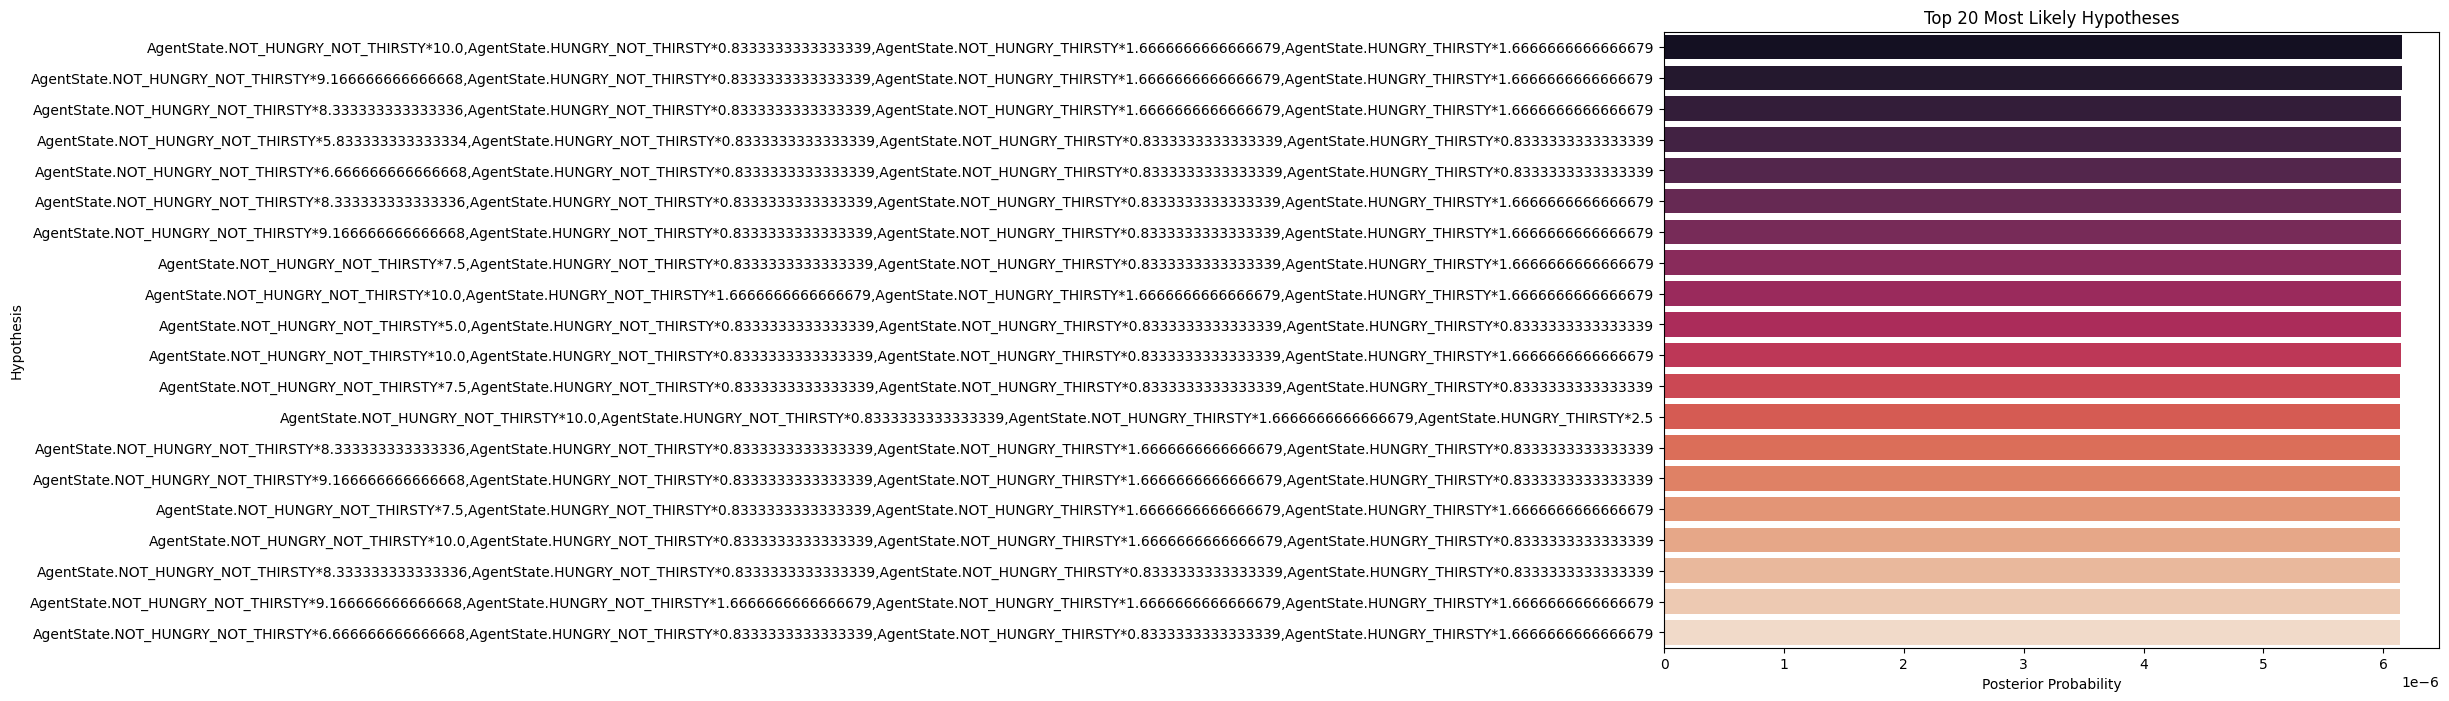

In [100]:
df = pd.DataFrame({'Hypothesis': [str(true_reward_matrix[i]) for i in list(range(len(true_reward_matrix)))], 'Probability': posterior})
df_sorted = df.sort_values(by='Probability', ascending=False)

top_n = 20
df_top = df_sorted.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x='Probability', y='Hypothesis', data=df_top, palette='rocket', hue='Hypothesis', legend=False)
plt.xlabel('Posterior Probability')
plt.ylabel('Hypothesis')
plt.title(f'Top {top_n} Most Likely Hypotheses')
plt.show()

In [281]:
np.random.seed(42)
env.render()

policy = [1, 1, 3, 3, 1, 1, 5]

# # policy = RandomPolicy(list(env.actions.keys()))
# for _ in range(len(policy)):
#   action = policy[_]
#   print(_)
#   # action = policy.call(env.get_state())
#   state, reward, done, info = env.step(action)
#   print(f"state: {state}, action: {action}")
#   # breakpoint()
#   env.render()

3
A . .|
. F .|
. . W 
 — —  
State: Hungry=True, Thirsty=True



In [37]:
env.mdp.get_transition_probability(env.mdp.get_state(2,4,AgentState.HUNGRY_NOT_THIRSTY), HungryThirstyAction.DRINK)

{(2, 4, <AgentState.HUNGRY_THIRSTY: 0>): (0.1, 0),
 (2, 4, <AgentState.HUNGRY_NOT_THIRSTY: 1>): (0.9, 0)}

In [1]:
#@title Old stuff

class HungryThirstyEnv:
    """
    An implementation of the Hungry-Thirsty domain from the paper
    "Where Do Rewards Come From?" by Singh, Lewis, and Barto (2009).
    """
    def __init__(self, food_loc: Tuple[int, int]=None, water_loc: Tuple[int, int]=None):
      self.grid_size = (6, 6)
      self.width, self.height = self.grid_size

      self.actions = {
        0: 'NORTH', 1: 'SOUTH', 2: 'WEST', 3: 'EAST',
        4: 'EAT', 5: 'DRINK'
      }
      self.action_space_size = len(self.actions)
      self.movement_actions = [0, 1, 2, 3]

      # Define the barriers that divide the grid into four 3x3 subspaces
      # Gaps exist to allow passage between subspaces.
      # A move from (x, 2) to (x, 3) is blocked if x != 2.
      # A move from (2, y) to (3, y) is blocked if y != 2.
      self.barriers = self._create_barriers()

      # The agent's state includes location, hunger, and thirst status [cite: 174]
      self.agent_pos: Tuple[int, int] = (0, 0)
      self.is_hungry: bool = True
      self.is_thirsty: bool = True

      # This flag tracks the previous state for hunger dynamics [cite: 127]
      self._was_not_hungry_last_step: bool = False

      # Food and water are in two randomly chosen corners [cite: 125]
      if food_loc is None:
        self.food_loc: Tuple[int, int] = (np.random.randint(0, self.width-1), np.random.randint(0, self.height-1))
      else:
        self.food_loc = food_loc
      if water_loc is None:
        self.water_loc: Tuple[int, int] = (np.random.randint(0, self.width-1), np.random.randint(0, self.height-1))
      else:
        self.water_loc = water_loc

    def _create_barriers(self) -> set:
        """Creates a set of blocked transitions based on the paper's description."""
        barriers = set()
        # Horizontal barrier with a gap at x=2
        for x in range(self.width):
          if x != 2:
            barriers.add(((x, 2), (x, 3))) # Southward movement
            barriers.add(((x, 3), (x, 2))) # Northward movement
        # Vertical barrier with a gap at y=2
        for y in range(self.height):
          if y != 2:
            barriers.add(((2, y), (3, y))) # Eastward movement
            barriers.add(((3, y), (2, y))) # Westward movement
        return barriers

    def reset(self) -> Tuple[int, int, bool, bool]:
        """
        Resets the environment for a new episode.
        - Randomly places food and water in two different corners.
        - Places the agent at a random location.
        - Resets hunger and thirst status.
        """
        # Food and water are at two distinct, randomly chosen corners
        corners = [(0, 0), (0, 5), (5, 0), (5, 5)]
        self.food_loc, self.water_loc = random.sample(corners, 2)

        # Start agent at a random location
        self.agent_pos = (random.randint(0, self.width-1), random.randint(0, self.height-1))

        self.is_hungry = True
        self.is_thirsty = True
        self._was_not_hungry_last_step = False

        return self.get_state()

    def get_state(self) -> Tuple[int, int, bool, bool]:
        """Returns the current state of the agent."""
        return (self.agent_pos[0], self.agent_pos[1], self.is_hungry, self.is_thirsty)

    def step(self, action: int) -> Tuple[Tuple, int, bool, Dict]:
        """
        Executes one time step in the environment.
        Returns: (next_state, reward, done, info)
        - reward is always 0, as reward is generated by the agent's internal critic.
        - info dictionary contains the fitness delta for this step.
        """
        # --- 1. Update Internal State Dynamics ---

        # If agent was not-hungry, it becomes hungry after one time step [cite: 127]
        if self._was_not_hungry_last_step:
          self.is_hungry = True
          self._was_not_hungry_last_step = False

        # If not-thirsty, agent becomes thirsty with p=0.1 [cite: 128]
        if not self.is_thirsty:
          if random.random() < 0.1:
            self.is_thirsty = True

        # --- 2. Execute Agent Action ---

        if action in self.movement_actions:
          self._move_agent(action)
        elif self.actions[action] == 'EAT':
          # Eat action fails if the agent is thirsty [cite: 170]
          if self.agent_pos == self.food_loc and not self.is_thirsty:
            self.is_hungry = False
        elif self.actions[action] == 'DRINK':
          if self.agent_pos == self.water_loc:
            self.is_thirsty = False

        # --- 3. Calculate Fitness and Prepare Return Values ---

        # Fitness increments by 1 for each time step the agent is not-hungry
        fitness_delta = 1 if not self.is_hungry else 0

        # Set flag for the next step's hunger dynamics
        if not self.is_hungry:
          self._was_not_hungry_last_step = True

        # The agent's interaction is continuous, not episodic
        done = False

        # According to the paper's framework, the environment itself does not provide rewards.
        # The agent's internal "critic" generates rewards based on the state.
        # We return the objective "fitness" value in the info dict.
        reward = 0
        info = {'fitness': fitness_delta}

        return self.get_state(), reward, done, info

    def _move_agent(self, action: int):
        """Calculates the agent's next position based on a move action."""
        x, y = self.agent_pos
        dx, dy = 0, 0
        if self.actions[action] == 'NORTH':
            dy = -1
        elif self.actions[action] == 'SOUTH':
            dy = 1
        elif self.actions[action] == 'WEST':
            dx = -1
        elif self.actions[action] == 'EAST':
            dx = 1

        new_pos = (x + dx, y + dy)

        # Check for grid boundaries and barriers [cite: 104]
        # Note: The paper mentions probabilistic movement but doesn't specify the model.
        # This is a deterministic implementation for simplicity.
        if (0 <= new_pos[0] < self.width and
            0 <= new_pos[1] < self.height and
            (self.agent_pos, new_pos) not in self.barriers):
            self.agent_pos = new_pos

    def render(self):
      """Prints a simple text-based representation of the grid."""
      print(self.width)
      grid = [['.' for _ in range(self.width)] for _ in range(self.height)]
      fx, fy = self.food_loc
      wx, wy = self.water_loc
      ax, ay = self.agent_pos

      grid[fy][fx] = 'F'
      grid[wy][wx] = 'W'
      grid[ay][ax] = 'A'

      for y in range(self.height):
          # Print the current content row (y)
          row_str = ""
          for x in range(self.width):
              row_str += grid[y][x]
              # Draw vertical barrier (or space) *after* the cell content
              if x == 2:
                  if y != 2:
                      row_str += "|"
                  else:
                      row_str += " "
              else:
                  row_str += " "
          print(row_str)

          # Draw horizontal barrier (if one exists *below* the current row y)
          if y == 2:  # The barrier is between row 2 and row 3
              barrier_line = ""
              for x in range(self.width):
                  # Add a separator for the cell content
                  barrier_line += " "
                  # Add the horizontal barrier symbol (or gap)
                  if x == 2:
                      barrier_line += " "
                  else:
                      barrier_line += "—"
              print(barrier_line)

      print(f"State: Hungry={self.is_hungry}, Thirsty={self.is_thirsty}\n")



def solve(self, mdp: HungryThirstyMdp, true_reward_matrix: list[Reward], true_log_prior: list[float]) -> list[float]:
    # 1. Compute expected features (evidence)
    expected_features = self._compute_feature_expectations(mdp)  # shape: (F,)

    # 2. Convert reward hypotheses to a matrix
    reward_matrix = np.array([r.weights for r in true_reward_matrix]) # shape: (H, F)

    # Normalize each row (axis=1) to have a length of 1
    reward_matrix = normalize(reward_matrix, norm='l2', axis=1)

    # --- Normalize the feature vector ---
    # Assuming expected_features is a 1D array
    expected_features = expected_features.reshape(1, -1) # Reshape for normalize
    expected_features = normalize(expected_features, norm='l2', axis=1).flatten() # Flatten back to 1D

    # 3. Calculate the unnormalized log likelihood for each hypothesis
    # This is the "energy": how well each reward explains the features
    # The result is a vector where each element corresponds to a hypothesis
    # log P(evidence | w_h) ∝ β * (features ⋅ w_h)
    unnormalized_log_likelihoods = self._beta * (expected_features @ reward_matrix.T) # shape: (H,)

    # 4. Calculate the unnormalized log posterior by adding the log prior
    # log P(w_h | evidence) ∝ log P(evidence | w_h) + log P(w_h)
    unnormalized_log_posterior = unnormalized_log_likelihoods + true_log_prior # shape: (H,)

    # 5. Normalize to get the final log posterior
    # The normalization constant is the log marginal likelihood, log P(evidence)
    log_marginal_likelihood = logsumexp(unnormalized_log_posterior)
    log_posterior = unnormalized_log_posterior - log_marginal_likelihood

    # 6. Convert from log space to get the final probability distribution
    posterior = np.exp(log_posterior)

    # --- Recommendation ---
    # If the posterior is still too spiky, the cause is your `_beta`.
    # Try running this with a smaller value, e.g., self._beta = 1.0

    return posterior

NameError: name 'Tuple' is not defined